<a href="https://colab.research.google.com/github/Hwajun1323/ML/blob/master/extract_frame/normal_layer/cross_validation_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras-metrics

In [ ]:
! pip install -q scikit-plot

In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier

import keras_metrics as km

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [ ]:
data_dir = "/content/drive/My Drive/Data/video_data"
image_dir = "/content/drive/My Drive/Data/image"
#data_dir = "video_data/"
img_height, img_width = 64, 64
seq_len = 20

classes = ["DiningRoom","Office", "Restaurant", "Museum", "ChildsRoom"]
num_classes = len(classes)
print("Number of Class: ", num_classes)

#  Creating frames from videos

def frames_extraction(video_path, c):
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    total_frames =int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT)) 
    frames_step = total_frames/seq_len

    # Used as counter variable
    count = 0
    #vidNum = 0

    while count < seq_len:
        for i in range(seq_len):
            vidObj.set(1,i*frames_step)
            success, image = vidObj.read()
            if success:
                #vidObj.set(cv2.CAP_PROP_POS_MSEC,(count*1000))
                #success, image = vidObj.read()
                try:
                    image = cv2.resize(image, (img_height, img_width))
                except:
                    break
                frames_list.append(image)

                name = '/content/drive/My Drive/Data/image/'+ str(c)+ '/'  +str(count)+'.jpg'

                cv2.imwrite(name,image)
                #print('Frame {} Extracted Successfully'.format(count))

                count += 1
            else:
                print("Defected frame")
                break
    #vidNum += 1       
    return frames_list

# Create the actual data from the sequence of images

def create_data(input_dir):
    X = []
    Y = []

    classes_list = os.listdir(input_dir)

    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        print(c, ': ' , len(files_list))
        print(c ,' index number : ', classes.index(c) )
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f),c)
            if len(frames) == seq_len:
                X.append(frames)

                y = [0] * len(classes)
                y[classes.index(c)] = 1
                #print(y)
                Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

Number of Class:  5


In [ ]:
X, Y = create_data(data_dir)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

Office
Office :  178
Office  index number :  1
Restaurant
Restaurant :  178
Restaurant  index number :  2
DiningRoom
DiningRoom :  178
DiningRoom  index number :  0
Museum
Museum :  178
Museum  index number :  3
ChildsRoom
ChildsRoom :  178
ChildsRoom  index number :  4


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
def create_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=False, data_format="channels_last", input_shape=(seq_len, img_height, img_width, 3)))
    model.add(Dropout(0.5))
    #model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), return_sequences=False, data_format="channels_last"))
    #model.add(Dropout(0.3))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    #model.summary()

    # Various optimizer

    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = keras.optimizers.SGD(lr=0.001)
    #opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    #opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    #opt = keras.optimizers.Adagrad(lr=0.001, epsilon=1e-6)
    #opt = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=None, decay=0.0)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=80, batch_size=40, verbose=0)
kfold = KFold(n_splits=3, shuffle=True, random_state=None) 
results = cross_val_score(model, X, Y, cv=kfold)

print('Result of Cross Validation:')
print('cross validation accuracy:',np.round(results, 4))
print('mean accuracy:', np.round(np.mean(results), 4))
print('std :', np.round(np.std  (results), 4))

Result of Cross Validation:
cross validation accuracy: [0.3569 0.4512 0.4054]
mean accuracy: 0.4045
std : 0.0385


In [ ]:
from sklearn.model_selection import cross_val_predict

model = KerasClassifier(build_fn=create_model, epochs=80, batch_size=40, verbose=0)
kfold = KFold(n_splits=3, shuffle=True, random_state=None) 
predicted = cross_val_predict(model, X, Y, cv=kfold)

print('Cross validation prediction done!')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



Classification report:
               precision    recall  f1-score   support

  DiningRoom       0.35      0.46      0.40       178
      Office       0.35      0.28      0.31       178
  Restaurant       0.45      0.54      0.49       178
      Museum       0.44      0.26      0.33       178
  ChildsRoom       0.46      0.49      0.48       178

    accuracy                           0.41       890
   macro avg       0.41      0.41      0.40       890
weighted avg       0.41      0.41      0.40       890

Confusion matrix: 



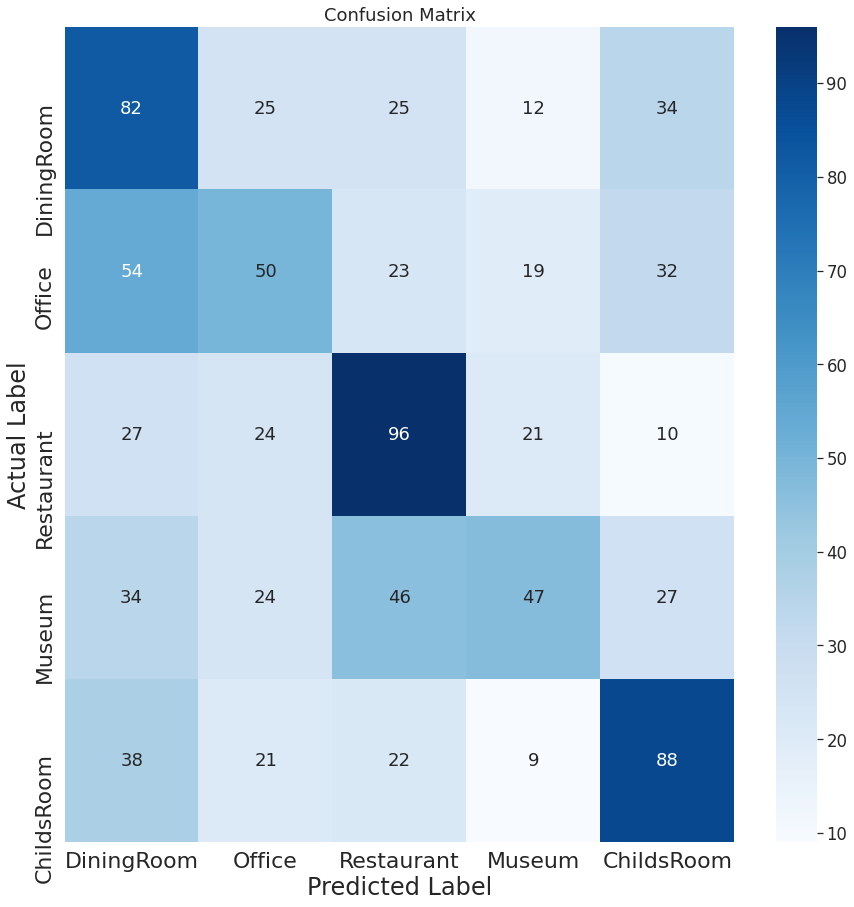

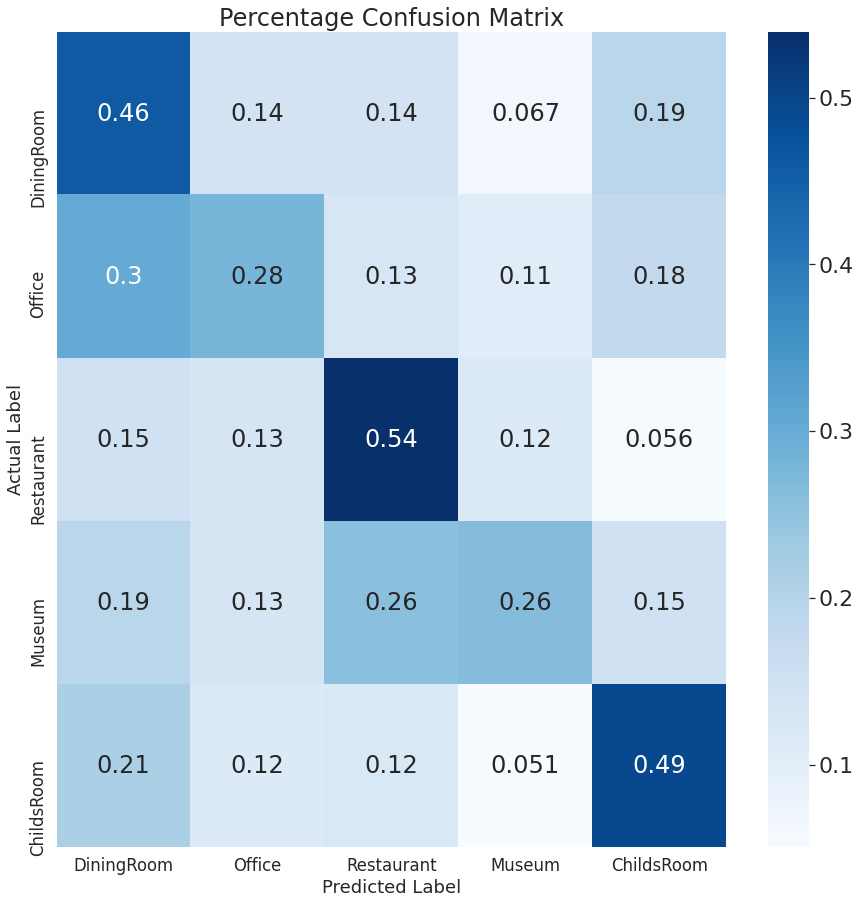

In [32]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


rounded_Y=np.argmax(Y, axis=1)


# Classification report 

targets = ['DiningRoom','Office', 'Restaurant', 'Museum', 'ChildsRoom']
print('\nClassification report:\n',classification_report(rounded_Y, predicted, target_names=targets))


# Confusion Matrix
cm = confusion_matrix(rounded_Y, predicted) 
print('Confusion matrix: \n')
#print(cm)

row1 = cm[0,:] / 178
row2 = cm[1,:] / 178
row3 = cm[2,:] / 178
row4 = cm[3,:] / 178
row5 = cm[4,:] / 178

norm_cm = np.vstack((row1, row2))
norm_cm = np.vstack((norm_cm, row3))
norm_cm = np.vstack((norm_cm, row4))
norm_cm = np.vstack((norm_cm, row5))
#print(norm_cm)

import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
x_axis_labels = ['DiningRoom','Office', 'Restaurant', 'Museum', 'ChildsRoom']
y_axis_labels = ['DiningRoom','Office', 'Restaurant', 'Museum', 'ChildsRoom'] 
sns.set(font_scale=1.5)
f = sns.heatmap(cm, cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
x_axis_labels = ['DiningRoom','Office', 'Restaurant', 'Museum', 'ChildsRoom']
y_axis_labels = ['DiningRoom','Office', 'Restaurant', 'Museum', 'ChildsRoom'] 
sns.set(font_scale=2.0)
f = sns.heatmap(norm_cm, cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.title("Percentage Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()